In [64]:
import os
import pandas as pd
import numpy as np
import earthpy as et

In [65]:
curr_timespan = '2014to2023'

fire_dir = os.path.join(et.io.HOME, 'earth-analytics', 'EA_fire_project')
data_dir = os.path.join(fire_dir, 'data')
out_dir = os.path.join(data_dir, 'original')
tmp_dir = os.path.join(data_dir, 'processed')

In [66]:
df = pd.read_csv(os.path.join(out_dir,
                                  'SIT209_HISTORY_INCIDENT_209_REPORTS_{}_cleaned.csv'.format(curr_timespan)), 
                     parse_dates=True,
                     low_memory=False)
# Remove unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [67]:
columns = ['INCIDENT_ID',
           'INC209R_IDENTIFIER',
           'REPORT_TO_DATE',
           'CURRENT_THREAT_12',
           'CURRENT_THREAT_24',
           'CURRENT_THREAT_48',
           'CURRENT_THREAT_72',
           'CURRENT_THREAT_GT72',
           'CURRENT_THREAT_NARR',
           'STR_THREATENED_RES',
           'STR_THREATENED',
           'STR_DESTROYED',
           'LIFE_SAFETY_HEALTH_STATUS_NARR']
# create a subset of the data
dfsub = df.loc[
    df.INCIDENT_ID.isin(
        ['2021_12993824_DIXIE','2021_12908560_CALDOR'])][columns].copy()
# Fill empty values with ''
collist = ['CURRENT_THREAT_12',
           'CURRENT_THREAT_24',
           'CURRENT_THREAT_48',
           'CURRENT_THREAT_72',
           'CURRENT_THREAT_GT72']
dfsub[collist] = dfsub[collist].fillna('')

In [68]:
df_norepeat = dfsub.copy()

for col in collist:
    # create a new column that shifts the current column down by one row
    df_norepeat['shifted'] = df_norepeat[col].shift(1)
    
    # Compare the current column with 'shifted'.
    new_col_name = f'unrepeated_{col}'
    df_norepeat[new_col_name] = (
        df_norepeat.apply(lambda row: 'same' if row[col] == row['shifted'] else row[col],
                    axis=1)
    )
    
    # Drop the temporary 'shifted' column after use
    df_norepeat.drop(columns=['shifted'], inplace=True)

In [69]:
df_norepeat['REPORT_TO_DATE']

# Convert 'REPORT_TO_DATE' to datetime format
df_norepeat['REPORT_TO_DATE'] = pd.to_datetime(df_norepeat['REPORT_TO_DATE'])

# Sort the DataFrame by 'REPORT_TO_DATE'
df_norepeat = df_norepeat.sort_values('REPORT_TO_DATE')

# Calculate the difference in hours and add as a new column
df_norepeat['last_reported'] = df_norepeat['REPORT_TO_DATE'].diff().dt.total_seconds() / 3600

<Axes: title={'center': 'Time between reports (hours)'}, ylabel='Frequency'>

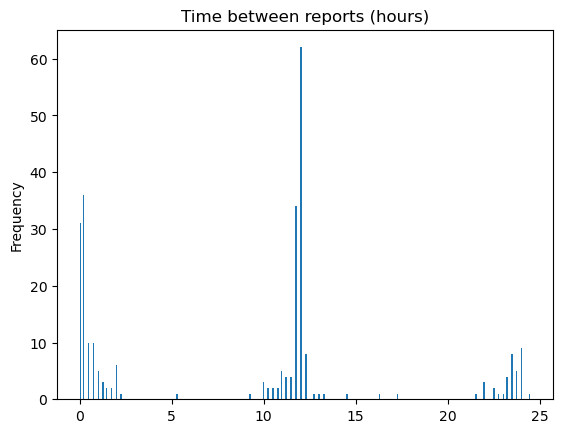

In [70]:
# time between reports in general
# could also be interesteing time between new 12 hours threats
# 12 hours threat has the least uncertainty? 12 hour lead time?
df_norepeat['last_reported'].plot(kind='hist', bins= len(df_norepeat), title='Time between reports (hours)')

In [51]:
# Calculate the percentage of repeated/unrepeated values
(df_norepeat['unrepeated_CURRENT_THREAT_12'] == 'same').sum() / len(df_norepeat)
(df_norepeat['unrepeated_CURRENT_THREAT_12'] != 'same').sum() / len(df_norepeat)

0.45652173913043476

In [26]:
dft = dfsub.copy()
# strip spaces
for col in collist:
    dft[col] = df[col].str.strip()

# initialize appended to False and consolidated narrative to empty string
dft['CURRENT_THREAT_NARR2'] = ''
for col in collist:
    time_frame = col.split('_')[-1]
    # strip to make sure not null
    if time_frame == '12':
        # initialize processed content
        dft.loc[dft[col] != '','prev_narr'] = dft['CURRENT_THREAT_12']
        dft.loc[dft[col] != '','time_label'] = time_frame
    else: 
        # later time_frame
        # equal to previous narrative - add time to time label
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() == dft['prev_narr'].str.lower()),
            'time_label'
            ]= dft.time_label + '/' + time_frame
        # not equal - append and re-initialize
        dft.loc[
            ((dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower())),
            'CURRENT_THREAT_NARR2'
            ] = dft.CURRENT_THREAT_NARR2 + \
                "\n" + dft.time_label + " Hours: " + \
                dft.prev_narr
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower()),
            'time_label'
            ] = time_frame
        dft.loc[
            (dft[col] != '') & (dft[col].str.lower() != dft['prev_narr'].str.lower()),
            'prev_narr'
            ] = dft[col]
# format narrative with time label
dft['CURRENT_THREAT_NARR2'] = (
    dft.CURRENT_THREAT_NARR2 + "\n" + \
    dft.time_label + " Hours: " + dft.prev_narr)
dft['CURRENT_THREAT_NARR2'] = dft.CURRENT_THREAT_NARR2.str.strip()
        

dft.to_csv(os.path.join(tmp_dir,'dixie-caldor-threat.csv'),index=False)